In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import emcee
import testkit
import corner
import pickle as pickle
from IPython.display import display
%matplotlib inline
import forwardmodel
import ciamod
import TPmod
import cloud
import band
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
from mikesconv import instrument_non_uniform

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
with open('2M0355_grey_ch4.pk1', 'rb') as input:
    sampler = pickle.load(input) 
print sampler.chain.shape


(336, 30000, 21)


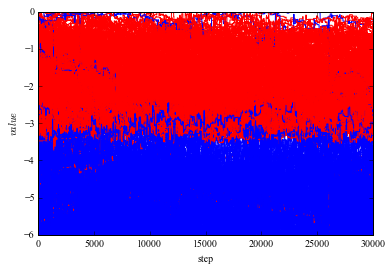

In [3]:
nwalkers = sampler.chain.shape[0]
niter = sampler.chain.shape[1]
ndim = sampler.chain.shape[2]
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0, niter, -6.0,0.])
index = np.arange(niter)
for i in range(0,nwalkers):
    plt.plot(index[:],sampler.chain[i,:,0],'r-')
    plt.plot(index[:],sampler.chain[i,:,1],'b-')
#    plt.plot(index[:],sampler.chain[i,:,2],'g-')
#    plt.plot(index[:],sampler.chain[i,:,3],'c-')
#    plt.plot(index[:],sampler.chain[i,:,4],'y-')
    
plt.ylabel(r'$value$')
plt.xlabel('step')


In [4]:
gassamples = sampler.chain[:,niter-1000:,0:10].reshape((-1,10))
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
print gassamples.shape
print gassamples[0:9,0:9]
print("autocorrelation time: {0:.3f}"
                .format(np.mean(sampler.acor)))
 

Mean acceptance fraction: 0.027
(336000, 10)
[[-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -7.57067728 -7.13388118
  -6.24667406 -7.42664093 -2.33899777]
 [-1.45785285 -4.2701164  -2.2741296  -6.18959902 -

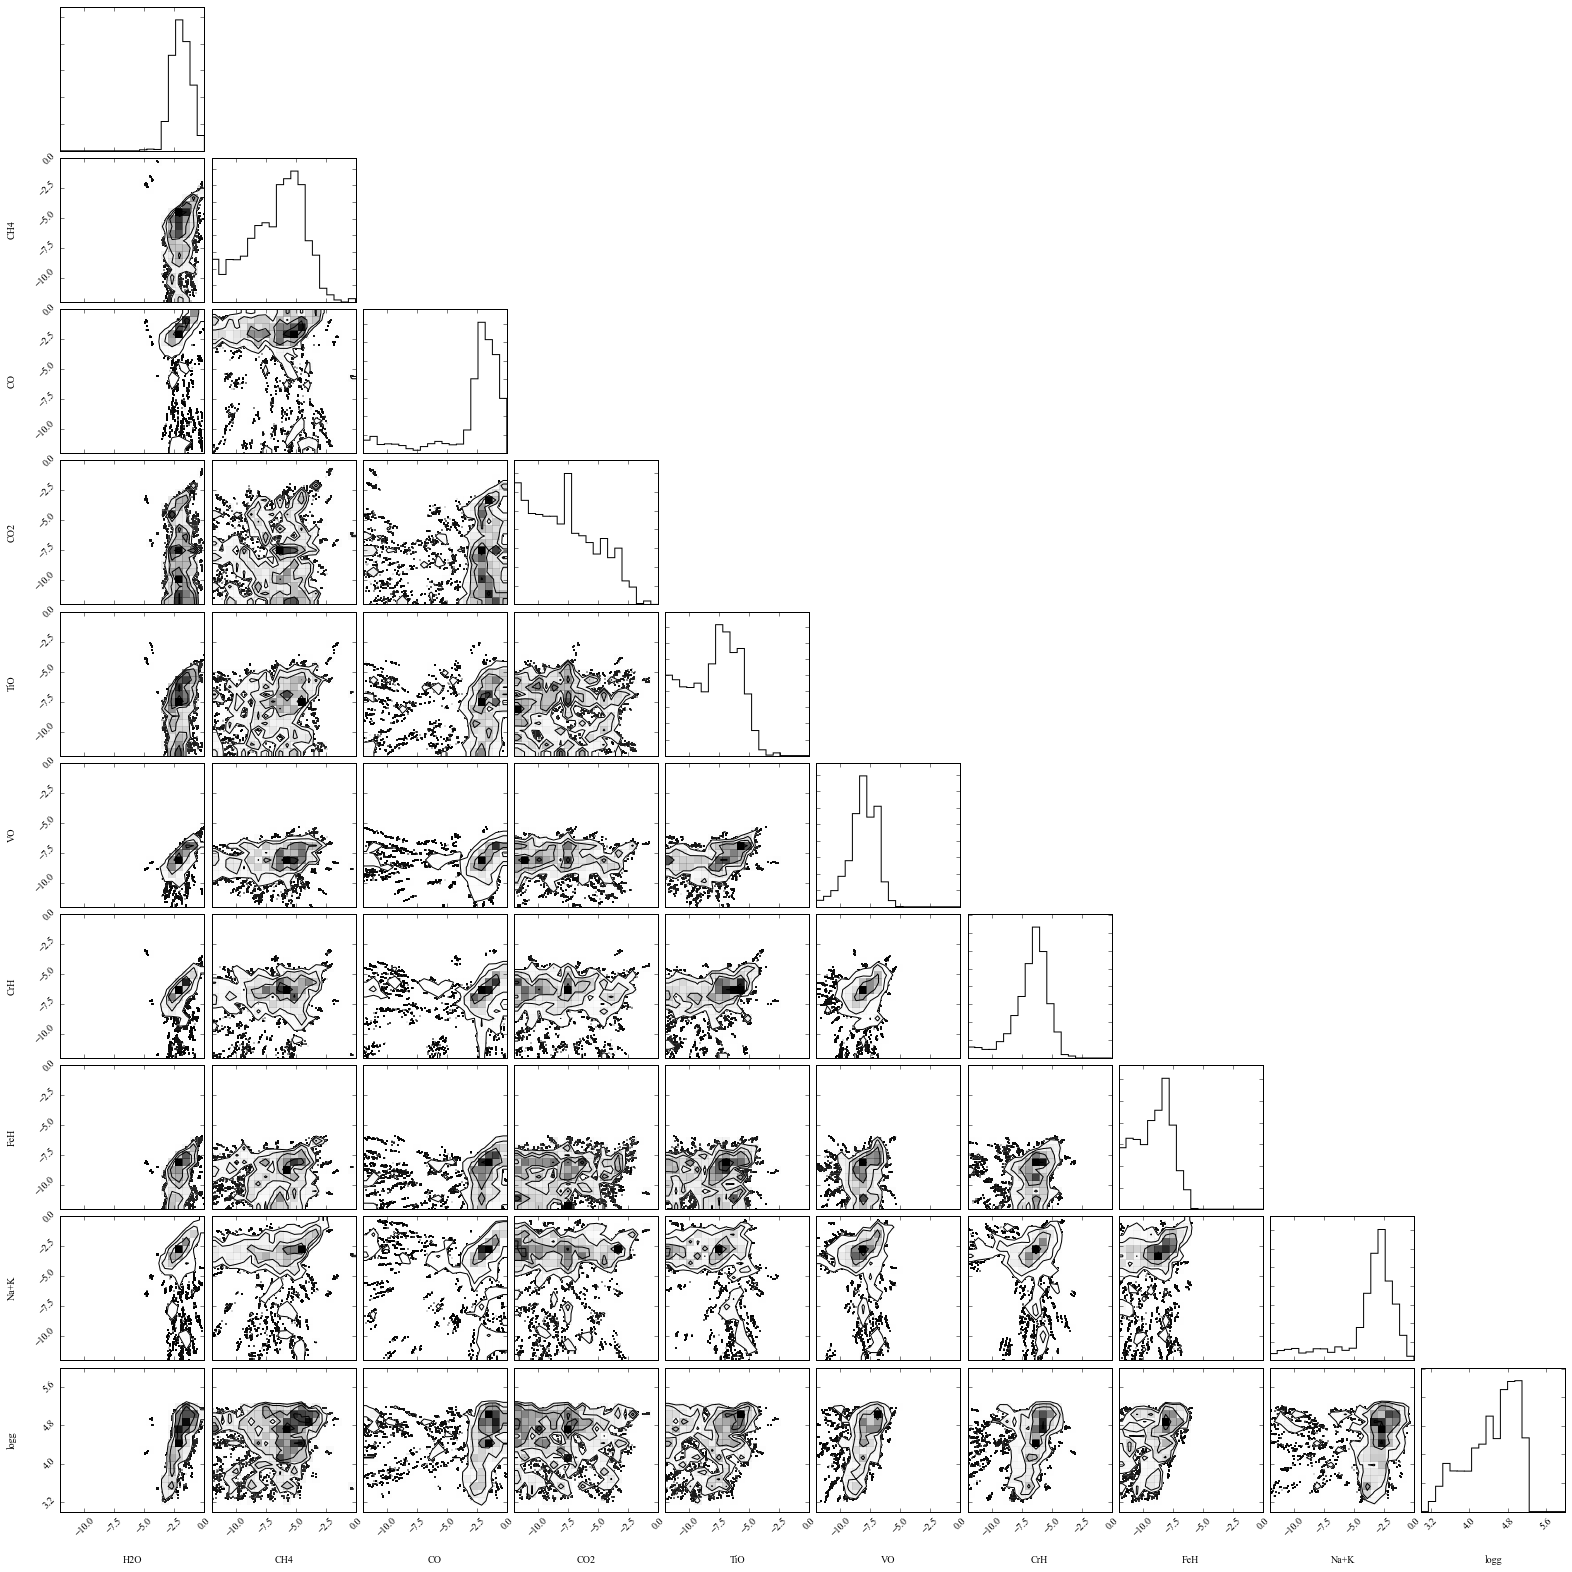

In [31]:
#b = 0.9
#bnds = [(-3.0,0.0),(-10.0,-4.0),(-6.0,0.0),(-12.,0.0),(-12.0,0.0),(-10.0,-6.0),(-9.0,-5.0),(-12.0,-7.0),(-7.0,0.0),(3.0,5.5)]
b = (-12.0,0.0)
bnds = [b,b,b,b,b,b,b,b,b,(3.0,6.0)]
fig = corner.corner(gassamples,labels=["H2O","CH4","CO","CO2","TiO","VO","CrH","FeH","Na+K","logg"],range=bnds)
#fig = triangle.corner(samples)
fig.savefig("2m0355_ch4_gascorner_equalranges.png")

In [6]:
#samples2 = gassamples[:,:]
#samples2[:, 4] = np.exp(samples[:, 4])
vmrlist = map(lambda v: (v[0], v[1], v[2]),
                             zip(*np.percentile(gassamples, [16, 50, 84],
                                                axis=0)))

In [7]:
print vmrlist
vmr = np.array(vmrlist)
# [-3.5,-3.4,-8.0,-7.5,-8.2]

[(-2.6652520842376735, -1.9421610440116153, -1.1027265596412481), (-9.3070314125020115, -6.2170662102959087, -4.4772967246425779), (-5.4118522299373204, -2.0171744059192998, -0.87663348232694971), (-10.95004907192315, -8.0859015777032948, -4.7007660994046869), (-10.648056850833957, -7.6759388487825415, -5.8214923110011298), (-9.3164607872707208, -8.0394614135586959, -6.9184814391372722), (-8.0946189601292104, -6.4970131056525222, -5.5024560567046397), (-10.949238786353719, -8.9368735468334677, -7.6684082236851472), (-6.0015905932541376, -3.0982754311270546, -1.9075438657632628), (3.8572143258424347, 4.5885235034116478, 5.0221301203997406)]


In [8]:
logP = np.arange(-4.0, 2.4, 0.1)  #high res grid
P = 10.**logP
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
print 10.**logcoarsePress
print logcoarsePress.size
print 10.**logP
print logP.size
finePress = P

[  1.00000000e-04   3.38844156e-04   1.14815362e-03   3.89045145e-03
   1.31825674e-02   4.46683592e-02   1.51356125e-01   5.12861384e-01
   1.73780083e+00   5.88843655e+00   1.99526231e+01   6.76082975e+01
   2.29086765e+02]
13
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.5118864

In [10]:
Tsamples = sampler.chain[:,niter-1000:,ndim-5:].reshape(-1,5)

nsamps = Tsamples.shape[0]
Tprofs = np.empty([64,Tsamples.shape[0]])
for i in range(0,nsamps):
    Tprofs[:,i] = TPmod.set_prof(2,10.**logcoarsePress,P,Tsamples[i,:])


In [11]:
# get the cloud stuff
cloudsamples = sampler.chain[:,niter-1000:,ndim-9:ndim-5].reshape(-1,4)



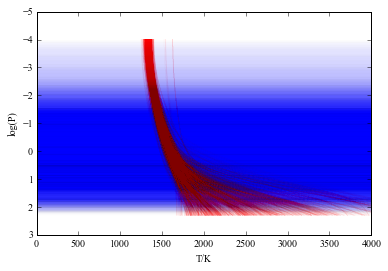

In [12]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([5., 4000.,3.0,-5.0])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.fill_between(T[:,1],T[:,2], logP,facecolor='red',interpolate=True)
#plt.plot(T[:,1],logP,'r--')
#plt.plot(T[:,2],logP,'r--')
sampT = np.empty(5)
sampcloud = np.empty(4)

for sampT[:] in Tsamples[(np.random.randint(len(Tsamples[:,:]), size=5000)),:]:
    plotT =TPmod.set_prof(2,10.**logcoarsePress,P,sampT[:])
    plt.plot(plotT,logP, color="r", alpha=0.01)

    
for sampcloud[:] in cloudsamples[(np.random.randint(len(cloudsamples[:,:]), size=5000)),:]:
    #plt.plot([0,4000.],[np.log10(sampcloud[0]),np.log10(sampcloud[0])],color="g",alpha=0.03)
    #plt.plot([0,4000.],[np.log10(sampcloud[0]+sampcloud[1]),np.log10(sampcloud[0]+sampcloud[1])],color="b",alpha=0.03)
    plt.fill_between([-100.,5000.0],sampcloud[1],(sampcloud[1] + sampcloud[2]),facecolor='blue',alpha=(sampcloud[0]/2000.))


plt.ylabel(r'log(P)')
plt.xlabel('T/K')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig('testspec.pdf',format='pdf', dpi=720)


In [13]:
#plt.savefig('2M2224_CO25_specFIT.pdf',format='pdf', dpi=720)

In [14]:
w1 = 0.8
w2 = 2.4

dist = 8.19
# hardwired FWHM of data in microns
fwhm = 0.005

npatches = 1
nclouds = 1
pcover = np.ones([npatches],dtype='f')
pcover[:] = 1.0
do_clouds = np.zeros([npatches],dtype='i')
do_clouds[:] = 1
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 99
cloudtype = np.array([npatches],dtype='i')
cloudtype[:] = 1

use_disort = 0 

# Set the profile type
proftype = 2

# now the linelist
# Set up number of gases, and point at the lists. see gaslist.dat
ngas = 10
gasnum = np.asfortranarray(np.array([1,2,4,5,7,8,10,11,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/ch4_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/co2_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/K_Mike_xsecs.pic","../Linelists/Na_Mike_xsecs.pic"]

In [15]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [16]:
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')

In [17]:
alkratio = 16.2 # Asplund+ 2009
logVMR = np.asfortranarray(np.ones([10,64]),dtype='float64')
print logVMR.shape


(10, 64)


In [18]:
outspec = np.zeros((2,nwave),dtype='d')
press = P
ng = 9
nc = 4
nb = 3

obspec = np.loadtxt("2M0355_2massJcalib.dat",unpack=True)
nobs = obspec.shape[1]

pltspec = np.zeros((5000,nobs))
samp= np.empty(ndim)
samples = sampler.chain[:,niter-1000:,:].reshape(-1,ndim)
sid = np.zeros(5000)
for i in range (0,5000):
    sid[i]= np.random.randint(0,high = len(samples))
    samp = samples[sid[i],:]
    logVMR[0,:] = np.full((npress,),(samp[0])) # water
    logVMR[1,:] = np.full((npress,),(samp[1])) # CH4
    logVMR[2,:] = np.full((npress,),(samp[2])) # CO
    logVMR[3,:] = np.full((npress,),(samp[3])) # CO2
    logVMR[4,:] = np.full((npress,),(samp[4])) # TiO
    logVMR[5,:] = np.full((npress,),(samp[5])) # VO
    logVMR[6,:] = np.full((npress,),(samp[6])) # CrH
    logVMR[7,:] = np.full((npress,),(samp[7])) # FeH
    logVMR[8,:]  = np.full((npress,),(np.log10(10.**samp[8] / (alkratio+1.))))
    logVMR[9,:]  = np.full((npress,),(np.log10(10.**samp[8] * (alkratio / (alkratio+1.)))))
    logg = samp[ng]
    R2D2 = samp[ng+1]
    dlam = samp[ng+2]
    cloudparams = np.ones([5],dtype='d')
    cloudparams[0] = samp[ng+3]
    cloudparams[1] = samp[ng+4]
    cloudparams[2] = samp[ng+5]
    cloudparams[3] = samp[ng+6]
    cloudparams[4] = 0.0
    #cloudparams[1:5] = samp[ng+nb:ng+nb+nc]
    cloudprof,cloudrad,cloudsig = cloud.atlas(do_clouds,cloudnum,cloudtype,cloudparams,press)
    cloudnum = np.asfortranarray(cloudnum,dtype='i')
    cloudrad = np.asfortranarray(cloudrad,dtype='float64')
    cloudsig = np.asfortranarray(cloudsig,dtype='float64')
    cloudprof = np.asfortranarray(cloudprof,dtype='float64')
    pcover = np.asfortranarray(pcover,dtype='float32')
    do_clouds = np.asfortranarray(do_clouds,dtype='i')

    temp = TPmod.set_prof(2,10.**logcoarsePress,P,samp[ng+nb+nc:])
    tmpoutspec = forwardmodel.marv(temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort)
    outspec = tmpoutspec[:,:nwave]
    wlen = outspec.shape[1]
    shiftspec = np.empty_like(outspec)
    shiftspec[0,:] =  outspec[0,:] + dlam
    shiftspec[1,:] =  outspec[1,:]   
    wavenew = obspec[0,:]
    wno = 1e4 / shiftspec[0,:]
    pltspec[i,:] = instrument_non_uniform(obspec[0,:],wno,shiftspec[1,:])

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
chisq = np.zeros(5000)
for i in range (0,5000):
    chisq[i] = sum(((pltspec[i,::3]) - obspec[1,::3])**2 / obspec[2,::3]**2) / (obspec.shape[1]/3)

In [20]:
print np.min(chisq)
best = np.argmin(chisq)
print best

0.301405561491
1496


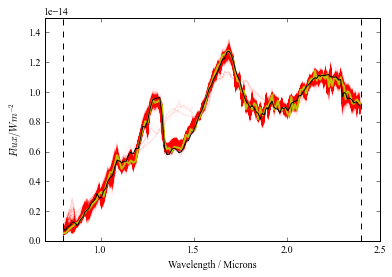

In [21]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7,2.5, 0.,15e-15])
for i in range(0,5000):
    plt.plot(wavenew[::3],pltspec[i,::3],color='r',alpha=0.01)
plt.plot(wavenew[::3],pltspec[best,::3],'y-',linewidth=2)
plt.plot(obspec[0,::3],obspec[1,::3],'k-')
plt.plot([2.4,2.4],[0,1.0],'k--')
plt.plot([0.8,0.8],[0,1.0],'k--')
plt.ylabel(r'$Flux/ Wm^{-2}$')
plt.xlabel('Wavelength / Microns')
plt.savefig('2M0355_specSPAG_grey_ch4.png',format='png', dpi=720)

In [22]:
print chisq.size
print samples[best,:]

5000
[ -1.73779661e+00  -7.72580772e+00  -1.17864059e+00  -3.52896733e+00
  -7.33838392e+00  -8.79102595e+00  -5.95248600e+00  -7.84890163e+00
  -2.61309359e+00   4.47315424e+00   1.12179005e-19   1.07642907e-03
   2.08346639e+00  -4.63921706e-01   7.68657151e-01   8.50041872e-01
   5.56626093e-01   1.26098001e-01  -1.88171871e-01   2.39830873e+00
   3.80884586e+03]


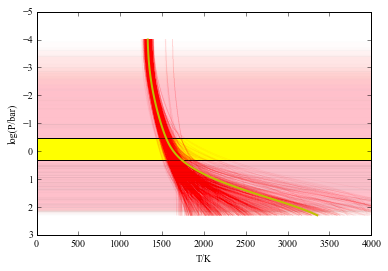

In [30]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([5., 4000.,3.0,-5.0])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.fill_between(T[:,1],T[:,2], logP,facecolor='red',interpolate=True)
#plt.plot(T[:,1],logP,'r--')
#plt.plot(T[:,2],logP,'r--')
sampT = np.empty(5)
savesampT = np.empty(5)
sampcloud = np.empty(4)

for sampT[:] in Tsamples[(np.random.randint(len(Tsamples[:,:]), size=5000)),:]:
    plotT =TPmod.set_prof(2,10.**logcoarsePress,P,sampT[:])
    plt.plot(plotT,logP, color="r", alpha=0.01)
    
    
for sampcloud[:] in cloudsamples[(np.random.randint(len(cloudsamples[:,:]), size=5000)),:]:
    #plt.plot([0,4000.],[np.log10(sampcloud[0]),np.log10(sampcloud[0])],color="g",alpha=0.03)
    #plt.plot([0,4000.],[np.log10(sampcloud[0]+sampcloud[1]),np.log10(sampcloud[0]+sampcloud[1])],color="b",alpha=0.03)
    plt.fill_between([-100.,5000.0],sampcloud[1],(sampcloud[1] + sampcloud[2]),facecolor='pink',alpha=(sampcloud[0]/2500.))


plotT =TPmod.set_prof(2,10.**logcoarsePress,P,samples[best,ndim-5:])
plt.fill_between([-100.,5000.0],samples[best,13],(samples[best,13]+samples[best,14]),facecolor='yellow',alpha=(1.0))
#plt.fill_between([-100.,5000.0],(0.5),(0.7),facecolor='yellow',alpha=(1./(5000/1500)))

plt.plot(plotT,logP,'y-',linewidth=2)
plt.ylabel(r'log(P/bar)')
plt.xlabel('T/K')
plt.savefig('2M0355_prof_SPAG_grey_ch4.png',format='png', dpi=720)